## Loading and Reevaluating Previous Model

This is just a sanity check that I'd like to make because th repository has been a mess in the recent while. So in order to check that this model has the same weights as the one reported in my last report, I am going to load it and then reevaluate it on the test set, and see if I get the same AUC score.

In [1]:
from keras.models import load_model
from keras.models import model_from_json
import json

# open json file and read content
with open('analysis_best_model/best_model.json','r') as f:
    json_string = f.readline()
# deserialize the json data into a keras model (only structure)
model = model_from_json(json_string)
# load the adjusted weights of the model
model.load_weights('analysis_best_model/best_model.h5')
# print a summary of the structure
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__________

### Read Dataset

In [20]:
import csv

smiles, y_test = [], []
with open('data/test.csv') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        if row[1] != 'smiles':
            # read smiles from the 2nd column
            smiles.append(row[1])
            # read labels from the 3rd column
            y_test.append(row[2])

In [21]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

info_dicts, X_test = [], []
for smile in smiles:
    m = Chem.MolFromSmiles(smile)
    info = {}
    bit_vector = AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=2048, bitInfo=info)
    X_test.append(bit_vector)
    info_dicts.append(info)
    
X_test = np.array(X_test)
y_test = np.array(y_test, dtype=np.int8)

### Evaluation

Done! No need to re-run this

In [23]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

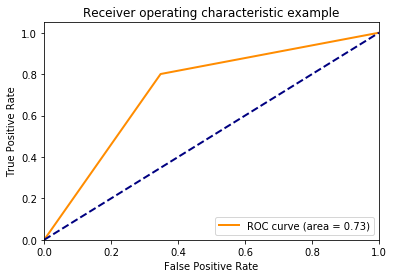

In [15]:
%matplotlib inline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_pred = model.predict_classes(X_test)
auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plot_roc(fpr, tpr, auc)

## Integrated Gradients

In the following we provide an implementation for the integrated gradients. Steps of the implementation are:
1. Consider a black image (each pixel 0) as a baseline
2. Now, interpolate a series of images , increasing in intensity, between the baseline image and the original image
3. The scores of these images (softmax output) when plotted, will look like the following.
4. Our region of interest lies where the slope of the score vs intensity graph doesn't remain stagnant. We call these gradients - *interesting gradients*
5. Gradients of the output with respect to these series of interpolated images, when calculated gives us the following
6. The integration of these series of gradients give us the Integrated gradients of the image.

*Right while I'm writing this implementation below, I came to realize that there's an easier way to get the gradients instead of calculating them manually, which through Keras's function `get_gradients()` of the Sequential model. **See therefore that you update the your model's implementation according to the Keras's new implementation**.*

#### Why/What it's not working

The function from **<font style="font-family: times; font-size: 14pt">Keras</font>** for calculating gradients isn't working.

In [31]:
prediction_tensor = model.predict(X_test) # prediciton tensor
input_tensor = X_test # input tensor
gradients = tf.gradients(prediction_tensor, input_tensor)
# compute the gradient of the input picture wrt this loss
# grads = K.gradients(loss, input_img)[0]

#### Author Implementation

In the following cell, I provide the implementation of the integrated gradients that the author provides (<u>not working</u>).

In [42]:
import tensorflow as tf
from keras import backend as keras
import numpy as np
# stub function
def input_tensor():
    return model.inputs
# stub function
def prediciton_tensor(label):
    return model.outputs

def integrated_gradients(inp, baseline, label, steps=50):
    t_input = input_tensor() # input tensor
    t_prediction = prediciton_tensor(label) # output tensor
    t_gradients = tf.gradients(t_prediction, t_input)[0] # gradients
    path_inputs = [baseline + (i/steps)*(inp-baseline) for i in range(steps)]
    grads = run_network(t_gradients, path_inputs)
    return (inp-baseline)*np.average(grads, axis=0) # integration

#### My Implementation 01

In the following, I provide my own implementation of the integrated gradients according to my understanding of the math formula (<u>not working</u>).

In [32]:
def own_integrated_gradients(input, baseline=None, steps=50):
    """My own implementation of the integrated gradients. I've made this over the formula under section "Computing
    Integrated Gradients". I'm not sure of the output of this function yet
    @Params
    ------
    input:        The input tensor.
    baselien:     The baseline tensor - if not provided, the zero-vector/tensor is calcualted.
    steps:        (Optional), number of steps for integral estimation.
    
    @Returns
    -------
    Not sure yet what the output is.
    """
    if baseline is None:
        baseline = np.zeros(shape=input.shape)
    path_integrals = [k.gradients(input[i], baseline + i/steps *(input-baseline)) for i in range(steps)]
    pp.pprint(path_integrals)
    return (input-baseline)*path_integrals*(1/m) # average

input = np.array(model.inputs)
own_integrated_gradients(input)

TypeError: Expected binary or unicode string, got <tf.Tensor 'add:0' shape=(?, 2048) dtype=float32>

#### My Implementation 02

According to the first formula in the paper

In [3]:
# how I would have written the implementation
from keras import backend as k

def integrated_gradients(input, baseline, interval_steps)
# check if a custom baseline is given
if baseline is None:
    baseline = np.zeros(shape=input.shape)
    
sum = 0
for i in range(interval_steps):
    sum += k.gradients(attribution*input + (1-attribution)*baseline)
return (input - baseline) * sum

## Using GitHub Implemention

Just for the sake of visualization, I'm using this package. However, once my implementation is successfully working, I will change it.

In [2]:
from modules.IntegratedGradients import integrated_gradients as IG
ig = IG(model)
ig.explain(X_test[0])

/Users/kareem/miniconda3/envs/molecules_and_ml/lib/python3.6/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Evaluated output channel (0-based index): All
Building gradient functions


AttributeError: 'NoneType' object has no attribute 'get_gradients'

## Visualizing the Attribution

apparently what needs to be done here is to replace the `DataStructs.TanimotoSimilarity` with the my own attribution score that I get, in order to visualize the attribution correctly. However, I still don't know what type of function that is.

Additionally, I should provide the zero-vector for the reference fingerprints.

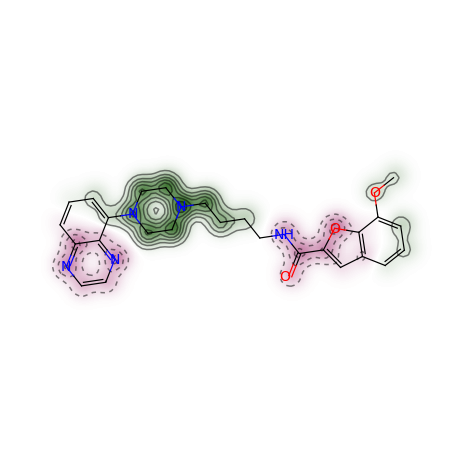

In [16]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import DataStructs

mol = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')

fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=3, fpType='count', nBits=2048),
                                                               metric=DataStructs.TanimotoSimilarity)